In [1]:
from scipy.linalg import hadamard
import numpy as np
import cv2
from matplotlib import pyplot as plt


In [2]:
int2bin = lambda x, n: format(x, 'b').zfill(n)


In [3]:
#
# The function generates an ideal low pass filter for frequency domain, 
# M and N are size of the filter/image, D0 is the cut_off point. 
# 
def idealLowPass(M, N, D0):
    # Initializing the filter with ones; since the filter is a complex function,
    # it has two channels, representing the real and imaginary parts:
    filter = np.ones((M, N), dtype=np.uint8)
    D0 = min(M,N) / 2 * D0
    # Scanning through each pixel and calculating the distance of each pixel
    # to the image center. If the pixel is within D0, it is changed to 0:
    for i in range(M):
        for j in range(N):
            if ( (i-M/2)**2 + (j-N/2)**2)**0.5 >= D0:
                filter[i,j]= 0
            
    return filter


In [4]:
def horder(b,nn): 
    jj = int2bin(b,nn)
    kk = ''
    for j in range(nn): 
        kk = kk+jj[nn-1-j] 
    
    kkk=np.zeros(nn) 
    kkk[0] = kk[0] 
    for j in range(1,nn):
        kkk[j] = int(kkk[j-1]) ^ int(kk[j]) 
        
    k=0
    for j in range(nn):
        k = k + int(kkk[j]) * 2**(nn-1-j)  

    return int(k)

In [5]:
# h = ordhad(n) 
# generate a n*n ordered hadamard matrix
# amir - may 2022
#

def ordhad(n): 
    h = hadamard(n)
    hh = hadamard(n)
    nn = np.log2(n)
    for i in range(n):
        k = horder(int(i) , int(nn)) 
        hh[k][:] = h[i][:]

    return hh

In [6]:
# setting the cut_off frequency to ...
ctf= 0.125

In [7]:
# ordered Hadamard Matrix
h = ordhad(512)


In [8]:
# reading and pre-processing of the image, it will be graylevel and 512x512
img = cv2.imread('../../Examples/set1/cat.bmp')

In [9]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(512,512))

In [10]:
# Had Transform
HI = np.matmul( h, np.matmul(img,h) )

In [11]:
'''There are three main ways to perform NumPy matrix multiplication:
dot(array a, array b) : returns the scalar or dot product of two arrays.
matmul(array a, array b) : returns the matrix product of two arrays.
multiply(array a, array b) : returns the element-wise matrix multiplication of two arrays.'''

'There are three main ways to perform NumPy matrix multiplication:\ndot(array a, array b) : returns the scalar or dot product of two arrays.\nmatmul(array a, array b) : returns the matrix product of two arrays.\nmultiply(array a, array b) : returns the element-wise matrix multiplication of two arrays.'

In [12]:
# our filters are designed for the Fourier domain, wher ethe origin of frequency access is
# in the middle of the matrix. in Hadamard and Cosine cases, that origin is in the [0,0] corner of the matrix
# so we go for a double filter size (here 1024x1024), but only keep its 4th quarter [512:1024,512:1024]
# that quarter is a good filter for Hadamard domain. 
#
h_lp_filt = idealLowPass(1024,1024,ctf)
h_lp_filt = h_lp_filt[512:1024,512:1024]
print(h_lp_filt.shape) 
# also, we can have Hadamard highpass filters
#h_lp_filt = 1 - h_lp_filt

(512, 512)


In [14]:
# filtering ...
HI = np.multiply(HI,h_lp_filt)

In [15]:
# inverse Hadamard, constant coeeficient is 1/ image size, here: 512x512 = 512**2
#
h2 = np.dot( np.matmul( h, np.matmul(HI,h)) , 1/(512**2) )
print(h2)

[[149.45533752 149.45533752 149.45533752 ...  42.9176712   42.9176712
   42.9176712 ]
 [149.45533752 149.45533752 149.45533752 ...  42.9176712   42.9176712
   42.9176712 ]
 [149.45533752 149.45533752 149.45533752 ...  42.9176712   42.9176712
   42.9176712 ]
 ...
 [ 46.67906952  46.67906952  46.67906952 ... 108.60693359 108.60693359
  108.60693359]
 [ 46.67906952  46.67906952  46.67906952 ... 108.60693359 108.60693359
  108.60693359]
 [ 46.67906952  46.67906952  46.67906952 ... 108.60693359 108.60693359
  108.60693359]]


In [16]:
# showing the result
cv2.imshow("Hadamard ID Cyl Filt",np.uint8(h2))
cv2.imshow("image",img)

cv2.waitKey(0)


13

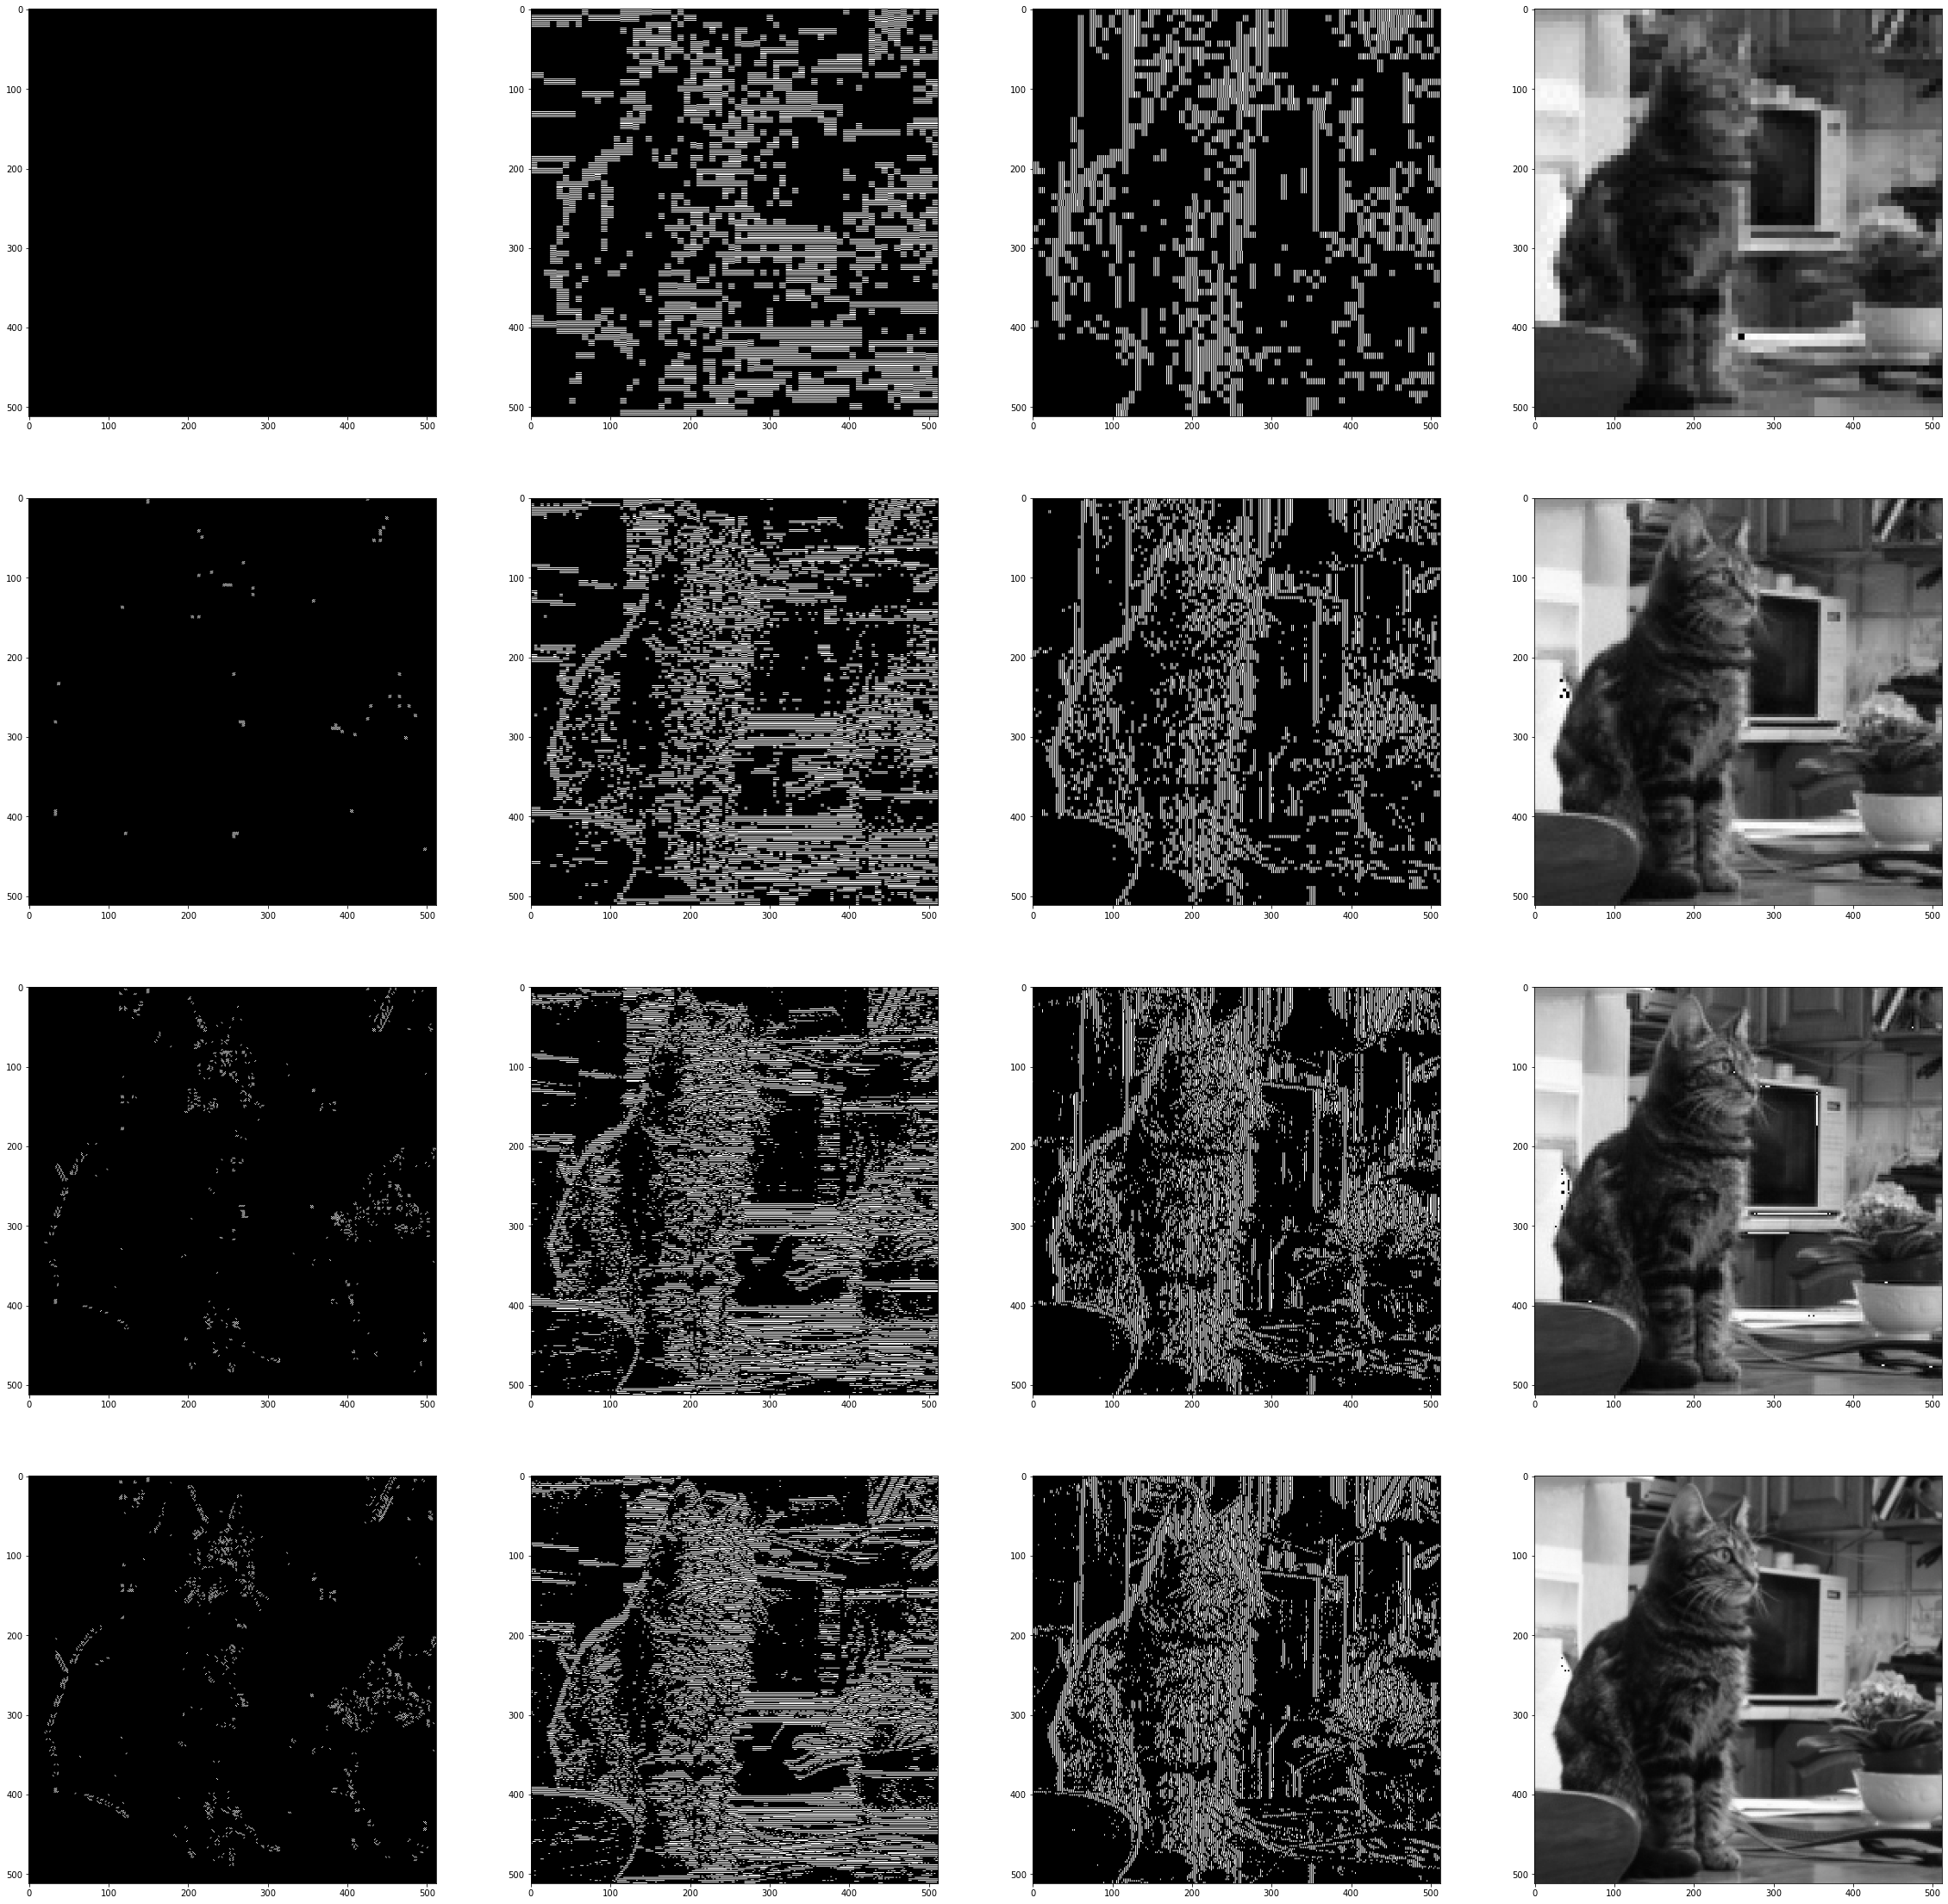

In [27]:
ctf_base= 0.125
h = ordhad(512)
HI = np.matmul( h, np.matmul(img,h) )
fig,axes = plt.subplots(4,4, figsize=(40, 40))
for ctf in range(4):
    for q in range(4):
        h_lp_filt = idealLowPass(1024,1024,ctf_base*(ctf+1))
        h_start = 512* (q//2)
        w_start = 512* (q%2)
        h_lp_filt_q = h_lp_filt[h_start:h_start+512,w_start:w_start+512]
        HI_f = np.multiply(HI,h_lp_filt_q)
        h2 = np.dot( np.matmul( h, np.matmul(HI_f,h)) , 1/(512**2))
        axes[ctf,q].imshow(h2.astype(np.uint8),'gray')